In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pickle
%matplotlib inline
import scipy.stats
import os

In [2]:
minfigsize = np.array([95,115])*0.0393701
maxfigsize = np.array([190,230])*0.0393701
plt.rc('font', size=8)
def rms(xx,xa):
    ss = xx-xa
    ss = ss**2
    ss = ss.sum(axis=0)
    ss = ss/40
    ss = np.sqrt(ss)
    return(ss)
wd = os.getcwd()

In [109]:
def Table2():
    fns = ['base.nc'] +['s'+str(i)+'.nc' for i in range(1,10)]
    print(' Run  | RMS Error (% of obs) ')
    for fn in fns:
        da = xr.load_dataarray(fn)
        print(' '+fn.split('.')[0]+' '*(8-len(fn))+'|     '+"{:.4f}".format(100*da.values.mean()/da.r.values))
Table2()

 Run  | RMS Error (% of obs) 
 base |     20.3059
 s1   |     20.1084
 s2   |     20.6152
 s3   |     29.5916
 s4   |     19.6315
 s5   |     20.3089
 s6   |     20.3404
 s7   |     20.4216
 s8   |     22.6087
 s9   |     19.4958


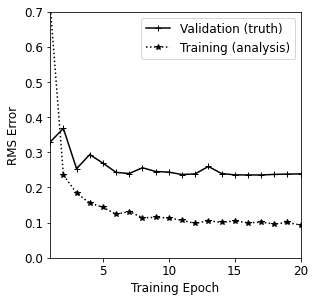

In [107]:
def Figure3(figname=None):
    val_rms = np.loadtxt('val_rms.txt')
    train_rms = np.loadtxt('train_rms.txt')
    plt.plot(range(1,21),val_rms,'k+-',label='Validation (truth)')
    plt.plot(range(1,21),train_rms,'k*:',label='Training (analysis)')
    plt.xticks([5,10,15,20])
    plt.xlim(1,20)
    plt.ylim([0,.7])
    plt.legend()
    plt.xlabel('Training Epoch')
    plt.ylabel('RMS Error')
    plt.gcf().set_size_inches(minfigsize[0]*1.2,minfigsize[1])
    if figname is not None:
        plt.savefig(figname)
Figure3()

In [108]:
def Table3():
    aug = []
    sparse = []
    fns = ['sparse_base.nc'] +['sparse'+str(i)+'.nc' for i in range(3,10)]
    for fn in fns:
        da = xr.load_dataarray(fn)
        sparse.append("{:.4f}".format(100*da.values.mean()))
    fns = ['a_base.nc'] +['a'+str(i)+'.nc' for i in range(3,10)]
    for fn in fns:
        da = xr.load_dataarray(fn)
        aug.append("{:.4f}".format(100*da.values.mean()))
    print(' Run |  Augmented  |    Sparse')
    print(' base|   '+aug[0]+'   |    '+sparse[0])
    for i in range(3,10):
        print('  s'+str(i)+' |   '+aug[i-2]+'   |    '+sparse[i-2])
Table3()

 Run |  Augmented  |    Sparse
 base|   74.9774   |    87.7121
  s3 |   78.1457   |    145.3896
  s4 |   73.7056   |    82.4292
  s5 |   75.0574   |    88.2805
  s6 |   75.3950   |    87.5605
  s7 |   75.8992   |    88.1500
  s8 |   87.3000   |    98.8954
  s9 |   72.7696   |    89.8549


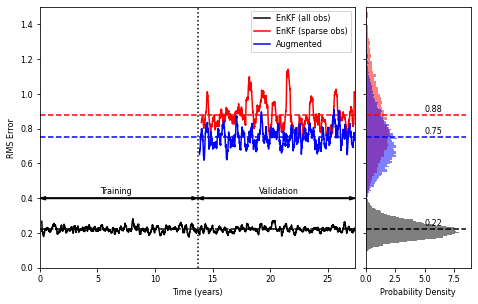

In [4]:
def Figure4(figname=None):
    plt.rc('font', size=8)
    windowsize = 12
    nt = int(windowsize/0.05)

    fig = plt.figure(figsize=[8,5])
    gs = fig.add_gridspec(1, 2,  width_ratios=(3, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[0, 0])
    ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)

    rmse = xr.open_dataarray('base.nc')
    rmse = rmse.assign_coords({'yrs':('time',(5*rmse.time/365).data)})
    rmse.rolling(time=nt).mean().plot.line(x='yrs',color='k',label='EnKF (all obs)',ax=ax)
    rms_means = [float(rmse.mean())]
    rmse.plot.hist(ax=ax_histy,bins=100,density=True,alpha=0.5,color='k',orientation='horizontal',histtype='stepfilled')

    rmse = xr.open_dataarray('sparse_base.nc')
    #rmse = rmse[rmse>0]
    rmse = rmse.assign_coords({'yrs':('time',(5*rmse.time/365).data)})
    rmse.rolling(time=nt).mean().plot.line(x='yrs',color='r',label='EnKF (sparse obs)',ax=ax)
    rms_means.append(float(rmse.mean()))
    rmse.plot.hist(ax=ax_histy,bins=200,density=True,alpha=0.5,color='r',orientation='horizontal',histtype='stepfilled')

    rmse = xr.open_dataarray('a_base.nc')
    #rmse = rmse[rmse>0]
    rmse = rmse.assign_coords({'yrs':('time',(5*rmse.time/365).data)})
    rmse.rolling(time=nt).mean().plot.line(x='yrs',color='b',label='Augmented',ax=ax)
    rmse.plot.hist(ax=ax_histy,bins=200,density=True,alpha=0.5,color='b',orientation='horizontal',histtype='stepfilled')
    rms_means.append(float(rmse.mean()))
    plt.sca(ax)
    plt.arrow(0,.4,1000*5/365,0,width = .004,color='k',length_includes_head=True,head_length=0.5,head_width=0.02)
    plt.arrow(1000*5/365,.4,-1000*5/365,0,width = .004,color='k',length_includes_head=True,head_length=0.5,head_width=0.02)
    plt.text(5.25,.425,'Training')
    plt.arrow(1000*5/365,.4,1000*5/365,0,width = .004,color='k',length_includes_head=True,head_length=0.5,head_width=0.02)
    plt.arrow(2000*5/365,.4,-1000*5/365,0,width = .004,color='k',length_includes_head=True,head_length=0.5,head_width=0.02)
    plt.text(19,.425,'Validation')
    plt.xlabel('Time (years)')
    plt.ylabel('RMS Error')
    plt.xlim([0,29])
    ax.legend()
    ax.hlines(rms_means,xmin=0,xmax=29,colors=['k','r','b'],linestyles=['--'])
    for val in rms_means:
        ax_histy.text(5,val+.02,"{:.2f}".format(val))
    plt.vlines(float(rmse.yrs.max())/2,0,1.5,colors='k',linestyles=':')
    plt.ylim([0,1.5])
    plt.xlim([0,2000*5/365])
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.hlines(rms_means[1],0,8.5,colors='r',linestyles='--')
    ax_histy.hlines(rms_means[2],0,8.5,colors='b',linestyles='--')
    ax_histy.hlines(rms_means[0],0,8.5,colors='k',linestyles='--')
    plt.sca(ax_histy)
    plt.xlabel('Probability Density')
    plt.gcf().set_size_inches(maxfigsize[0],maxfigsize[1]*.5)
    #plt.gcf().set_size_inches(maxfigsize[0],maxfigsize[1]*.6)
    if figname is not None:
        plt.savefig(figname)
rmscompare()

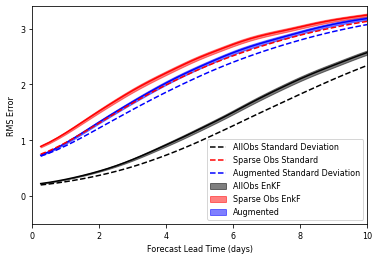

In [50]:
def Figure5(figname):
    ds = xr.load_dataset('forecasts.nc')
    ds = ds.assign_coords(({'days':('time',(5*ds.time).data)}))
    ds.rmssparse.plot.line(x ='days',color='r')
    ds.denserms.plot.line(x='days',color='k')
    ds.augrms.plot.line(x='days',color='b')
    zscore = 1.96
    tmax = 3
    ti = np.arange(0.05, tmax,0.05)
    tplotmax = 2
    npts = 1000
    idx = int(len(ti)*tplotmax/tmax)+1

    plt.fill_between(ti[:idx]*5,ds.denserms[:idx]+zscore*ds.densestd[:idx]/np.sqrt(npts),ds.denserms[:idx]-zscore*ds.densestd[:idx]/np.sqrt(npts),color='k',label='AllObs EnKF',alpha=.5)

    plt.fill_between(ti[:idx]*5,ds.rmssparse[:idx]+zscore*ds.stdsparse[:idx]/np.sqrt(npts),ds.rmssparse[:idx]-zscore*ds.stdsparse[:idx]/np.sqrt(npts),color='r',label='Sparse Obs EnkF',alpha=.5)

    plt.fill_between(ti[:idx]*5,ds.augrms[:idx]+zscore*ds.augstd[:idx]/np.sqrt(npts),ds.augrms[:idx]-zscore*ds.augstd[:idx]/np.sqrt(npts),color='b',label='Augmented',alpha=.5)

    ds.dense_ens_std.plot.line(x='days',color='k',linestyle='--',label='AllObs Standard Deviation')
    ds.sparse_ens_std.plot.line(x='days',color='r',linestyle='--',label='Sparse Obs Standard')
    ds.aug_ens_std.plot.line(x='days',color='b',linestyle='--',label='Augmented Standard Deviation')

    plt.gcf().set_size_inches(6,4)
    plt.ylim([-.5,3.4])
    plt.xlim([0,10])
    plt.yticks(np.array([0,1,2,3]))
    plt.xlabel('Forecast Lead Time (days)')
    plt.ylabel('RMS Error')
    if figname is not None:
        plt.savefig(figname)
    plt.legend(loc=4)
Figure5()

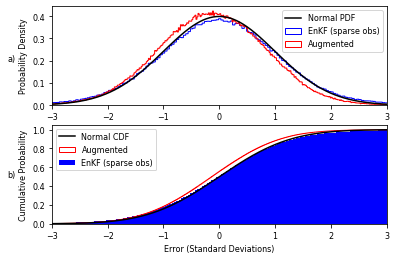

In [61]:
def Figure6(figname=None):
    plt.subplots(2,1)
    plt.subplot(2,1,1)
    x=np.linspace(-5,5,500)
    plt.plot(x,scipy.stats.norm.pdf(x),'k',label='Normal PDF')
    err = xr.load_dataarray('errors_sparse.nc')
    err.plot.hist(bins=1250,density=True,histtype='step',color='b',label='EnKF (sparse obs)')

    err = xr.load_dataarray('errors_augmented.nc')
    err.plot.hist(bins=1000,density=True,histtype='step',color='r',label='Augmented')
    plt.xlim([-3,3])
    plt.ylabel('Probability Density')
    plt.legend()
    plt.text(-3.8,.2,'a)')


    plt.subplot(2,1,2)
    x=np.linspace(-5,5,500)
    plt.plot(x,scipy.stats.norm.cdf(x),'k',label='Normal CDF')

    err = xr.load_dataarray('errors_augmented.nc')
    err.plot.hist(bins=1000,density=True,histtype='step',color='r',label='Augmented',cumulative=True)

    err = xr.load_dataarray('errors_sparse.nc')
    err.plot.hist(bins=1250,density=True,histtype='bar',color='b',label='EnKF (sparse obs)',cumulative=True)
    plt.xlim([-3,3])
    plt.text(-3.8,.5,'b)')
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Error (Standard Deviations)')
    plt.legend()

    if figname is not None:
        plt.savefig(figname)
Figure6()

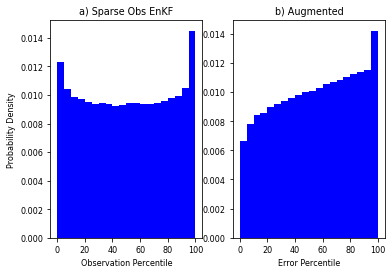

In [65]:
def Figure7(figname=None):
    ranks_sparse = np.load('sparseranks.npy')
    ranks_aug = np.load('augranks.npy')
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    plt.title('a) Sparse Obs EnKF')
    plt.hist(ranks_sparse,bins=20,color='b',density=True)
    plt.ylabel('Probability Density')
    plt.xlabel('Observation Percentile')
    plt.subplot(1,2,2)
    plt.hist(ranks_aug,bins=20,color = 'b',density=True)
    plt.xlabel('Error Percentile')
    plt.title('b) Augmented')
    if figname is not None:
        plt.savefig(figname)
Figure7()

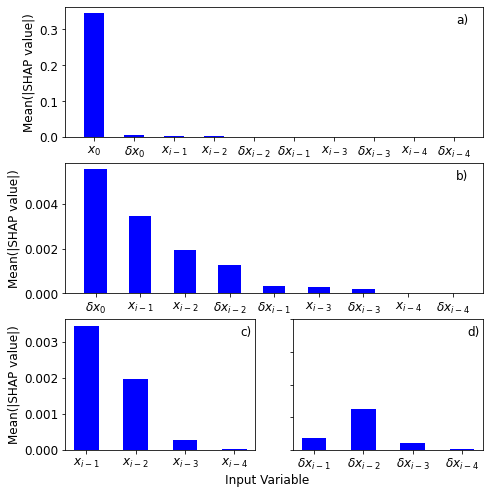

In [67]:
def Figure8(figname=None):
    plt.rc('font', size=12)
    plt.subplots(3,1)
    plt.subplot(3,1,1)
    shapvals = np.loadtxt('shapvals.txt')
    shapvals = np.abs(shapvals).mean(axis=0)
    names=['$x_{0}$','$x_{i-1}$','$x_{i-2}$','$x_{i-3}$','$x_{i-4}$',r'$\delta x_{0}$',r'$\delta x_{i-1}$',r'$\delta x_{i-2}$',r'$\delta x_{i-3}$',r'$\delta x_{i-4}$']
    lst = [x for _, x in sorted(zip(shapvals,names))]
    lst.reverse()
    shapvals.sort()
    shapvals = shapvals[::-1]
    bars = plt.bar(lst,shapvals,width=.5,color='b')
    plt.ylabel('Mean(|SHAP value|)')
    plt.text(.95,.9, 'a)', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
    plt.subplot(3,1,2)
    bars = plt.bar(lst[1:],shapvals[1:],width=.5,color='b')
    plt.ylabel('Mean(|SHAP value|)')
    plt.subplot(3,1,2)
    shapvals = np.loadtxt('shapvals.txt')
    shapvals = np.abs(shapvals).mean(axis=0)
    names=['$x_{0}$','$x_{i-1}$','$x_{i-2}$','$x_{i-3}$','$x_{i-4}$',r'$\delta x_{0}$',r'$\delta x_{i-1}$',r'$\delta x_{i-2}$',r'$\delta x_{i-3}$',r'$\delta x_{i-4}$']
    bars = plt.bar(names[6:],shapvals[6:],width=.5,color='b')
    #plt.gca().invert_yaxis()
    #plt.gca().bar_label(bars, fmt='%.2e')
    #plt.xlim([0,0.015])
    plt.ylabel('Mean(|SHAP value|)')
    #plt.title('SHAP Values')
    plt.text(.95,.9, 'b)', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)

    plt.subplot(3,2,5)
    shapvals = np.loadtxt('shapvals.txt')
    shapvals = np.abs(shapvals).mean(axis=0)
    names=['$x_{0}$','$x_{i-1}$','$x_{i-2}$','$x_{i-3}$','$x_{i-4}$',r'$\delta x_{0}$',r'$\delta x_{i-1}$',r'$\delta x_{i-2}$',r'$\delta x_{i-3}$',r'$\delta x_{i-4}$']
    bars = plt.bar(names[1:5],shapvals[1:5],width=.5,color='b')
    #plt.gca().invert_yaxis()
    #plt.gca().bar_label(bars, fmt='%.2e')
    #plt.xlim([0,0.015])
    plt.ylabel('Mean(|SHAP value|)')
    plt.text(.95,.9, 'c)', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
    plt.xlabel(' '*55+'Input Variable')
    plt.subplot(3,2,6)
    shapvals = np.loadtxt('shapvals.txt')
    shapvals = np.abs(shapvals).mean(axis=0)
    names=['$x_{0}$','$x_{i-1}$','$x_{i-2}$','$x_{i-3}$','$x_{i-4}$',r'$\delta x_{0}$',r'$\delta x_{i-1}$',r'$\delta x_{i-2}$',r'$\delta x_{i-3}$',r'$\delta x_{i-4}$']
    bars = plt.bar(names[6:],shapvals[6:],width=.5,color='b')
    #plt.gca().invert_yaxis()
    #plt.gca().bar_label(bars, fmt='%.2e')
    #plt.xlim([0,0.015])
    #plt.title('SHAP Values')
    plt.text(.95,.9, 'd)', horizontalalignment='center',
     verticalalignment='center', transform=plt.gca().transAxes)
    plt.ylim([0,0.004])
    plt.gca().yaxis.set_ticklabels([])
    plt.gcf().set_size_inches([maxfigsize[0],maxfigsize[1]*.9])
    if figname is not None:
        plt.savefig(figname)
Figure8()